In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import pprint as pp

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part G: Vansjø

Using Vannmiljø and NVE Atlas, the following datasets are available for Vansjø:

 * **Discharge:** The main outflow is NVE station 3.23.0 (Moss dam ndf.), and then upstream there is 3.22.0 (Høgfoss ), which could be area-scaled for the upstream sub-catchments.

 * **Water chemsitry:** I have used Vannmiljø to extract data for all stations within vassdragsområde 003. This is filtered below to find suitable stations.

## 1. Filter water chemistry

For fluxes, I will focus on river stations with at least 6 samples per year.

In [3]:
# Read Vannmiljø export
xl_path = r"/home/jovyan/shared/common/teotil3/evaluation/vannmiljo_export_vassom-003_2011-2022.xlsx"
wc_df = pd.read_excel(
    xl_path, sheet_name="data", parse_dates=["Tid_provetak"], decimal=","
)
wc_df["year"] = wc_df["Tid_provetak"].dt.year

# Separate station details
loc_dict = {
    "Vannlokalitet_kode": "station_code",
    "Vannlokalitetsnavn": "station_name",
    "Type": "type",
    "UTM33 Ost (X)": "utm_east",
    "UTM33 Nord (Y)": "utm_north",
}
stn_df = wc_df[loc_dict.keys()].copy()
stn_df.rename(columns=loc_dict, inplace=True)
stn_df["utm_zone"] = 33
stn_df.drop_duplicates(inplace=True)

# Separate chem
chem_dict = {
    "Vannlokalitet_kode": "station_code",
    "Type": "type",
    "Parameter_id": "parameter",
    "Medium_navn": "medium",
    "year": "year",
    "Tid_provetak": "sample_date",
    "Ovre_dyp": "depth1",
    "Nedre_dyp": "depth2",
    "Operator": "flag",
    "Verdi": "value",
    "Enhet": "unit",
    "Filtrert_Prove": "filtered",
}
wc_df = wc_df[chem_dict.keys()].copy()
wc_df.rename(columns=chem_dict, inplace=True)
wc_df[["depth1", "depth2"]] = wc_df[["depth1", "depth2"]].fillna(value=0)
wc_df.drop_duplicates(inplace=True)
display(stn_df.head())
display(wc_df.head())

station_code                   station_name    type     utm_east  \
0     003-51039          Kallerødbekken (KA03)     Elv  258463.7427   
21    003-54545                      Sværsvann  Innsjø  269676.5623   
29    003-51505              Råde kommune St 4     Elv  262448.3461   
31    003-51506  Akerbekken, Råde kommune St 5     Elv  260805.1419   
33    003-51507              Råde kommune St 6     Elv  258812.1462   

       utm_north  utm_zone  
0   6.577953e+06        33  
21  6.638030e+06        33  
29  6.583800e+06        33  
31  6.584373e+06        33  
33  6.585995e+06        33

station_code type parameter     medium  year sample_date  depth1  depth2  \
0    003-51039  Elv     P-TOT  Ferskvann  2011  2011-04-12     0.0     0.0   
1    003-51039  Elv     P-TOT  Ferskvann  2011  2011-05-10     0.0     0.0   
2    003-51039  Elv     P-TOT  Ferskvann  2011  2011-06-07     0.0     0.0   
3    003-51039  Elv     P-TOT  Ferskvann  2011  2011-07-05     0.0     0.0   
4    003-51039  Elv     P-TOT  Ferskvann  2011  2011-08-02     0.0     0.0   

  flag  value    unit   filtered  
0    =   28.0  µg/l P  Ufiltrert  
1    =   31.0  µg/l P  Ufiltrert  
2    =   41.0  µg/l P  Ufiltrert  
3    =   85.0  µg/l P  Ufiltrert  
4    =   68.0  µg/l P  Ufiltrert

In [4]:
samp_thresh = 6  # Min. samples per year
depth_thresh = 1  # Max. depth for samples
st_yr, end_yr = 2013, 2022
types = ["Elv"]
mediums = ["Ferskvann"]

# Pars of interest
par_dict = {
    "N-TOT_Ufiltrert_µg/l N": "TOTN_ug/l",
    "P-TOT_Ufiltrert_µg/l P": "TOTP_ug/l",
}

In [5]:
# Filter
stn_df = stn_df.query("type in @types")
wc_df = wc_df.query(
    "(type in @types) and "
    "(medium in @mediums) and "
    "(year >= @st_yr) and "
    "(year <= @end_yr) and "
    "(depth1 <= @depth_thresh) and "
    "(depth2 <= @depth_thresh)"
)
count_df = (
    wc_df.groupby(["station_code", "year", "parameter", "filtered"])
    .count()[["sample_date"]]
    .reset_index()
)
count_df = count_df.query("sample_date	 >= @samp_thresh")
valid_stn_list = list(count_df["station_code"].unique())
wc_df = wc_df.query("station_code in @valid_stn_list")

# Convert to wide
wc_df["par_unit"] = wc_df["parameter"] + "_" + wc_df["filtered"] + "_" + wc_df["unit"]
wc_df.drop(
    columns=[
        "type",
        "parameter",
        "medium",
        "year",
        "depth1",
        "depth2",
        "flag",
        "unit",
        "filtered",
    ],
    inplace=True,
)

# Depth average samples
wc_df = wc_df.groupby(["station_code", "par_unit", "sample_date"]).mean()
wc_df = wc_df.unstack("par_unit")

# Just stations with complete data for pars of interest
wc_df.columns = wc_df.columns.get_level_values(1)
wc_df = wc_df[par_dict.keys()]
wc_df.rename(columns=par_dict, inplace=True)
wc_df = wc_df.reset_index().dropna()
valid_stn_list = list(wc_df["station_code"].unique())
stn_df = stn_df.query("station_code in @valid_stn_list")

print(len(stn_df), "stations with data.")
display(stn_df.head())
display(wc_df.head())

31 stations with data.


station_code                 station_name type     utm_east     utm_north  \
0      003-51039        Kallerødbekken (KA03)  Elv  258463.7427  6.577953e+06   
39     003-56290  Heiabekken ovenfor jernbane  Elv  261227.4000  6.587478e+06   
802    003-27942                  Veidalselva  Elv  267659.8000  6.601274e+06   
832    003-27945                       Svinna  Elv  270214.3000  6.596263e+06   
868    003-27946                     Mørkelva  Elv  269211.0000  6.601707e+06   

     utm_zone  
0          33  
39         33  
802        33  
832        33  
868        33

par_unit station_code sample_date  TOTN_ug/l  TOTP_ug/l
16         003-102097  2021-02-11     1700.0       90.0
17         003-102097  2021-02-18     1000.0       60.0
18         003-102097  2021-03-25     4900.0       97.0
34         003-102098  2020-12-10     3300.0      110.0
37         003-102098  2021-01-14     2600.0       45.0

In [6]:
# Convert co-ordinates
stn_df = nivapy.spatial.utm_to_wgs84_dd(
    stn_df, zone="utm_zone", east="utm_east", north="utm_north"
)
stn_df.drop(columns=["utm_zone", "utm_east", "utm_north"], inplace=True)

nivapy.spatial.quickmap(stn_df, lon_col="lon", lat_col="lat", popup="station_code")

In [7]:
# Identify suitable stations
# Get NVE stations
dis_stn_dict = {
    "003-30718": "3.23.0",
    "003-27953": "3.22.0",
    "003-59191": "3.22.0",
}
regine_dict = {
    "003-30718": "003.A3",
    "003-27953": "003.CZ",
    "003-59191": "003.C0",
}
stn_df = stn_df.query("station_code in @dis_stn_dict.keys()").reset_index(drop=True)
wc_df = wc_df.query("station_code in @dis_stn_dict.keys()")
stn_df["nve_dis_stn_id"] = stn_df["station_code"].map(dis_stn_dict)
stn_df["regine"] = stn_df["station_code"].map(regine_dict)
stn_df

station_code                     station_name type        lat        lon  \
0    003-27953                     Kråkstadelva  Elv  59.595340  10.895590   
1    003-30718  Mosseelva oppstrøms Mossefossen  Elv  59.439361  10.670646   
2    003-59191               Hobølelva ved Kure  Elv  59.529086  10.839371   

  nve_dis_stn_id  regine  
0         3.22.0  003.CZ  
1         3.23.0  003.A3  
2         3.22.0  003.C0

In [8]:
# Test for outliers
id_cols = ["station_code", "sample_date"]
pars = list(par_dict.values())
df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
stn_list = df["station_code"].unique().tolist()
for stn_id in stn_list:
    for par in pars:
        stn_par_df = df.query(
            "(station_code == @stn_id) and (parameter == @par)"
        ).copy()
        if len(stn_par_df) > 0:
            stn_par_df["outlier"] = nivapy.stats.double_mad_from_median(
                stn_par_df["value"], thresh=3
            )
            df_list.append(stn_par_df)
df = pd.concat(df_list)
df.head()

station_code sample_date  parameter   value  outlier
0    003-27953  2013-04-17  TOTN_ug/l  2600.0    False
1    003-27953  2013-05-14  TOTN_ug/l  2900.0    False
2    003-27953  2013-06-11  TOTN_ug/l  2100.0    False
3    003-27953  2013-07-10  TOTN_ug/l  3500.0    False
4    003-27953  2013-08-06  TOTN_ug/l  3300.0    False

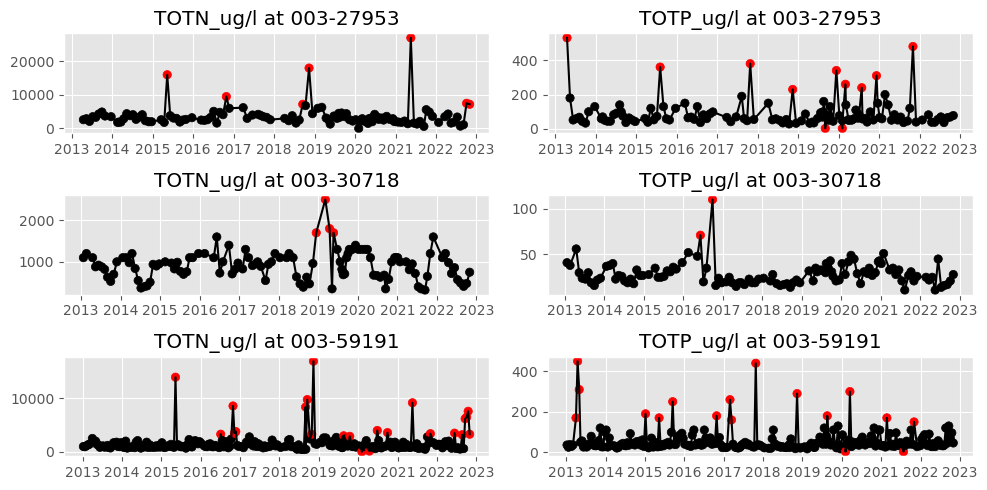

In [9]:
fig, axes = plt.subplots(nrows=len(stn_list), ncols=2, figsize=(10, 5))

for row_idx, stn_id in enumerate(stn_list):
    for col_idx, par in enumerate(pars):
        stn_par_df = df.query(
            "(station_code == @stn_id) and (parameter == @par)"
        ).copy()
        stn_par_df.sort_values("sample_date", inplace=True)
        stn_par_df["outlier_col"] = ["r" if i else "k" for i in stn_par_df["outlier"]]
        axes[row_idx, col_idx].plot(
            stn_par_df["sample_date"], stn_par_df["value"], "k-"
        )
        axes[row_idx, col_idx].scatter(
            stn_par_df["sample_date"],
            stn_par_df["value"],
            c=stn_par_df["outlier_col"].tolist(),
        )
        axes[row_idx, col_idx].set_title(f"{par} at {stn_id}")
plt.tight_layout()

In [10]:
# Remove outliers
df = (
    df.query("outlier == False")
    .drop(columns="outlier")
    .set_index(["station_code", "sample_date", "parameter"])
    .unstack("parameter")
)
df.columns = df.columns.get_level_values(1)
wc_df = df.reset_index()
wc_df.head()

parameter station_code sample_date  TOTN_ug/l  TOTP_ug/l
0            003-27953  2013-04-17     2600.0        NaN
1            003-27953  2013-05-14     2900.0      180.0
2            003-27953  2013-06-11     2100.0       52.0
3            003-27953  2013-07-10     3500.0       60.0
4            003-27953  2013-08-06     3300.0       68.0

## 2. Catchment boundaries for water chemistry sites

In [11]:
wc_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="station_code",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 003:   0%|          | 0/3 [00:00<?, ?it/s]

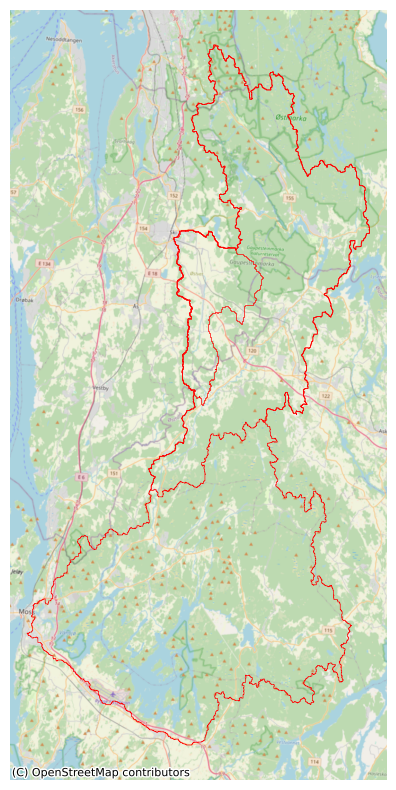

In [12]:
# Plot
ax = wc_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=wc_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 3. Get NVE discharge

In [13]:
# Get par ID for discharge
par_df = nivapy.da.get_nve_hydapi_parameters()
par_df = par_df.query("parameterName == 'Vannføring'")
par_df

parameter parameterName parameterNameEng  unit
2       1001    Vannføring        Discharge  m³/s

In [14]:
# Get NVE stations
nve_ids = stn_df["nve_dis_stn_id"].unique().tolist()
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df = nve_stn_df.query("station_id in @nve_ids")
nve_stn_df

station_id   station_name  latitude  longitude  utmEast_Z33  \
1198     3.22.0        Høgfoss  59.55161   10.85610       265842   
1199     3.23.0  Moss dam ndf.  59.43872   10.66828       254419   

      utmNorth_Z33  masl        riverName councilNumber    councilName  ...  \
1198       6608781    53  Mossevassdraget          3118  Indre Østfold  ...   
1199       6596905     9  Mossevassdraget          3103           Moss  ...   

        culQ5   culQ10   culQ20   culQ50    culHm    culH5   culH10   culH20  \
1198  66.9112  74.5639  80.6114  86.9155  40.9231  41.0731  41.1415  41.1916   
1199  55.0000  62.0000  68.0000  75.0000      NaN      NaN      NaN      NaN   

       culH50                                         seriesList  
1198  41.2408  [{'parameterName': 'Vannstand', 'parameter': 1...  
1199      NaN  [{'parameterName': 'Vannstand', 'parameter': 1...  

[2 rows x 98 columns]

In [15]:
# Get discharge data
par_ids = [1001]
st_dt = f"{st_yr-2}-01-01"
end_dt = f"{end_yr+2}-01-01"
q_df = nivapy.da.query_nve_hydapi(nve_ids, par_ids, st_dt, end_dt, resolution=1440)
q_df.head()

station_id   station_name parameter parameter_name parameter_name_eng  \
0     3.23.0  Moss dam ndf.      1001     Vannføring          Discharge   
1     3.23.0  Moss dam ndf.      1001     Vannføring          Discharge   
2     3.23.0  Moss dam ndf.      1001     Vannføring          Discharge   
3     3.23.0  Moss dam ndf.      1001     Vannføring          Discharge   
4     3.23.0  Moss dam ndf.      1001     Vannføring          Discharge   

  method                  datetime  value  unit  correction  quality  
0   Mean 2011-01-01 11:00:00+00:00    1.0  m³/s           0        3  
1   Mean 2011-01-02 11:00:00+00:00    1.0  m³/s           0        3  
2   Mean 2011-01-03 11:00:00+00:00    1.0  m³/s           0        3  
3   Mean 2011-01-04 11:00:00+00:00    1.0  m³/s           0        3  
4   Mean 2011-01-05 11:00:00+00:00    1.0  m³/s           0        3

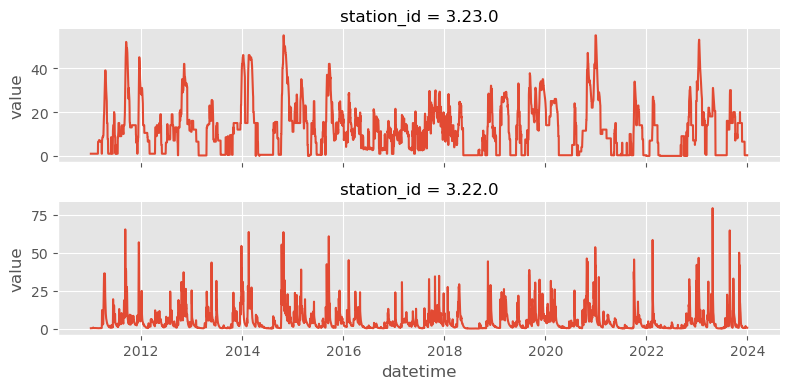

In [16]:
# Plot
sn.relplot(
    data=q_df,
    x="datetime",
    y="value",
    row="station_id",
    kind="line",
    aspect=4,
    height=2,
    facet_kws={"sharey": False, "sharex": True},
)

In [17]:
# Linearly interpolate NoData gaps (i.e. where valid values exist either side of gap),
# but no extrapolation. ALso limit to period where we have complete data for all sites
q_df = (
    q_df.pivot(columns="station_id", index="datetime", values="value")
    .resample("D")
    .mean()
    .interpolate(method="linear", limit_area="inside")
    .dropna(how="any")
)

# Remove time zone info
q_df.index = q_df.index.tz_localize(None)

q_df.head()

station_id    3.22.0  3.23.0
datetime                    
2011-01-01  0.343704     1.0
2011-01-02  0.343907     1.0
2011-01-03  0.335210     1.0
2011-01-04  0.331774     1.0
2011-01-05  0.338922     1.0

## 4. Catchment boundaries for discharge sites

In [18]:
q_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 003:   0%|          | 0/2 [00:00<?, ?it/s]

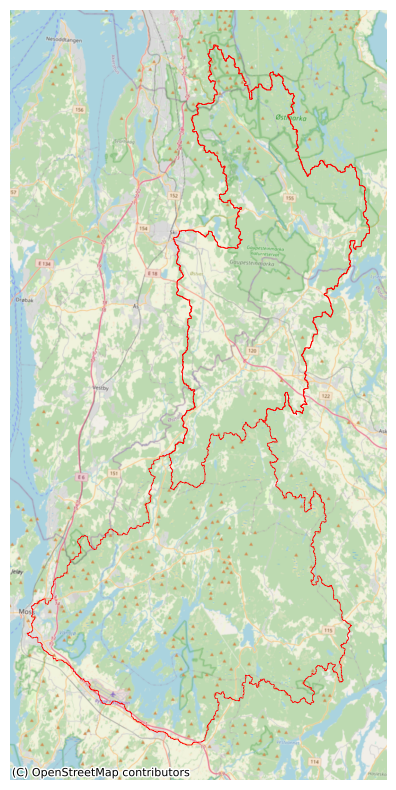

In [19]:
# Plot
ax = q_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=q_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [20]:
# Calculate catchment areas and join chem to dis data
wc_gdf["area_km2"] = wc_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf["area_km2"] = q_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf.rename({"station_id": "nve_dis_stn_id"}, axis="columns", inplace=True)
wc_gdf = wc_gdf.merge(
    q_gdf[["nve_dis_stn_id", "area_km2"]],
    how="left",
    on="nve_dis_stn_id",
    suffixes=["_chem", "_dis"],
)
wc_gdf

station_code                                           geometry  \
0    003-27953  POLYGON ((267200.000 6627760.000, 267200.000 6...   
1    003-30718  MULTIPOLYGON (((276080.000 6612760.000, 276080...   
2    003-59191  MULTIPOLYGON (((271920.000 6610600.000, 271920...   

                      station_name type        lat        lon nve_dis_stn_id  \
0                     Kråkstadelva  Elv  59.595340  10.895590         3.22.0   
1  Mosseelva oppstrøms Mossefossen  Elv  59.439361  10.670646         3.23.0   
2               Hobølelva ved Kure  Elv  59.529086  10.839371         3.22.0   

   regine  area_km2_chem  area_km2_dis  
0  003.CZ      49.643587    300.475043  
1  003.A3     693.888661    693.928634  
2  003.C0     304.971757    300.475043

## 5. Estimate fluxes

In [21]:
df_list = []
for method in [
    # "linear_interpolation",
    # "simple_means",
    # "log_log_linear_regression",
    "ospar_annual",
]:
    for idx, row in wc_gdf.iterrows():
        name = row["station_name"]
        chem_id = row["station_code"]
        dis_id = row[["nve_dis_stn_id"]]
        site_wc_df = (
            wc_df.query("station_code == @chem_id")
            .copy()
            .set_index("sample_date")[["TOTP_ug/l", "TOTN_ug/l"]]
            .resample("D")
            .mean()
        )
        site_q_df = q_df[dis_id].copy()

        # Scale flows to match chem sites
        area_fac = row["area_km2_chem"] / row["area_km2_dis"]
        site_q_df[dis_id] = area_fac * site_q_df[dis_id]
        site_q_df.columns = ["flow_m3/s"]

        flux_df = nivapy.stats.estimate_fluxes(
            site_q_df,
            site_wc_df,
            base_freq="D",
            agg_freq="A",
            method=method,
            st_date=f"{st_yr}-01-01",
            end_date=f"{end_yr}-12-31",
            plot_fold=None,
        )
        flux_df["station_code"] = chem_id
        flux_df["station_name"] = name
        flux_df["method"] = method

        if method != "ospar_annual":
            del flux_df["flow_m3"]
            flux_df["year"] = flux_df.index.year
            flux_df.reset_index(inplace=True, drop=True)
        else:
            flux_df.reset_index(inplace=True)

        df_list.append(flux_df)

flux_df = pd.concat(df_list, axis="rows")

# Convert kgs to tonnes
for col in ["TOTP_kg", "TOTN_kg"]:
    par = col.split("_")[0]
    flux_df[f"{par}_tonnes"] = flux_df[col] / 1000
    del flux_df[col]

flux_df.drop(columns=["method"], inplace=True)

flux_df = pd.merge(
    flux_df, stn_df[["station_code", "regine"]], how="left", on="station_code"
)

flux_df.head()

year station_code  station_name  TOTP_tonnes  TOTN_tonnes  regine
0  2013    003-27953  Kråkstadelva     3.553820    72.002288  003.CZ
1  2014    003-27953  Kråkstadelva     2.232966    79.301571  003.CZ
2  2015    003-27953  Kråkstadelva     3.363342    80.546947  003.CZ
3  2016    003-27953  Kråkstadelva     1.913887    75.138416  003.CZ
4  2017    003-27953  Kråkstadelva     2.132583    92.117232  003.CZ

## 7. Model results

In [22]:
nve_data_year = 2023
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [23]:
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

regine regine_down  accum_agriculture-background_din_kg  \
0    001.10        001.                             0.000000   
1  001.1A2B    001.1A2A                           123.574401   
2  001.1A4D    001.1A4C                            15.917595   
3    001.1M      001.1L                             0.000000   
4    001.21        001.                             0.000000   

   accum_agriculture-background_ss_kg  accum_agriculture-background_tdp_kg  \
0                            0.000000                             0.000000   
1                            0.752367                             3.420677   
2                            0.289332                             0.117126   
3                            0.000000                             0.000000   
4                            0.000000                             0.000000   

   accum_agriculture-background_toc_kg  accum_agriculture-background_ton_kg  \
0                             0.000000                             0.000000   
1                          6341.957239                            68.505729   
2                           464.712746                             6.729665   
3                             0.000000                             0.000000   
4                             0.000000                             0.000000   

   accum_agriculture-background_totn_kg  accum_agriculture-background_totp_kg  \
0                              0.000000                              0.000000   
1                            192.080130                              3.609359   
2                             22.647261                              0.149627   
3                              0.000000                              0.000000   
4                              0.000000                              0.000000   

   accum_agriculture-background_tpp_kg  ...  local_urban_tpp_kg  \
0                             0.000000  ...                 0.0   
1                             0.188682  ...                 5.6   
2                             0.032501  ...                 0.0   
3                             0.000000  ...                 0.0   
4                             0.000000  ...                 0.0   

   local_wood_din_kg  local_wood_ss_kg  local_wood_tdp_kg  local_wood_toc_kg  \
0               36.1             849.2                0.6             9938.9   
1             1318.1           29798.4               23.9           384175.8   
2              237.2            5272.5                4.3            70016.3   
3              473.5           11104.0                8.8           142788.5   
4                5.0             117.0                0.1             1386.1   

   local_wood_ton_kg  local_wood_totn_kg  local_wood_totp_kg  \
0              186.2               222.3                 5.4   
1             7138.8              8456.9               210.0   
2             1296.4              1533.6                38.2   
3             2641.6              3115.1                78.3   
4               25.9                30.9                 0.8   

   local_wood_tpp_kg  year  
0                4.8  2013  
1              186.1  2013  
2               33.9  2013  
3               69.5  2013  
4                0.7  2013  

[5 rows x 164 columns]

In [24]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
        del mod_df[col]

# Merge
comp_df = pd.merge(flux_df, mod_df, how="left", on=["regine", "year"])
comp_df.head()

year station_code  station_name  TOTP_tonnes  TOTN_tonnes  regine  \
0  2013    003-27953  Kråkstadelva     3.553820    72.002288  003.CZ   
1  2014    003-27953  Kråkstadelva     2.232966    79.301571  003.CZ   
2  2015    003-27953  Kråkstadelva     3.363342    80.546947  003.CZ   
3  2016    003-27953  Kråkstadelva     1.913887    75.138416  003.CZ   
4  2017    003-27953  Kråkstadelva     2.132583    92.117232  003.CZ   

     q_m3/s  upstr_area_km2  agriculture-background_din_tonnes  \
0  0.618967       50.138381                           6.253589   
1  1.028399       50.138381                           9.116979   
2  0.995519       50.138381                           7.376384   
3  0.611947       50.138381                           5.961478   
4  0.636335       50.138381                           5.830139   

   agriculture-background_ss_tonnes  ...  urban_totp_tonnes  urban_tpp_tonnes  \
0                         84.300976  ...           0.151369          0.054955   
1                        168.648638  ...           0.251200          0.091170   
2                        161.548293  ...           0.243391          0.088300   
3                         82.823972  ...           0.149508          0.054280   
4                         87.575016  ...           0.155654          0.056475   

   wood_din_tonnes  wood_ss_tonnes  wood_tdp_tonnes  wood_toc_tonnes  \
0         0.806586       18.697587         0.016793       152.721668   
1         1.338123       18.697587         0.027857       253.361380   
2         1.296757       18.697587         0.026968       245.529465   
3         0.796220       18.697587         0.016596       150.763737   
4         0.829391       18.697587         0.017287       157.029192   

   wood_ton_tonnes  wood_totn_tonnes  wood_totp_tonnes  wood_tpp_tonnes  
0         3.028833          3.835419          0.092346         0.075553  
1         5.024669          6.362792          0.153216         0.125359  
2         4.869321          6.166078          0.148444         0.121475  
3         2.989922          3.786141          0.091136         0.074540  
4         3.114220          3.943611          0.094951         0.077663  

[5 rows x 82 columns]

In [25]:
nibio_df = pd.DataFrame(
    {
        "year": range(2013, 2023),
        "TOTP_tonnes": [
            11.6,
            15.6,
            16.2,
            10.6,
            6.9,
            6.3,
            12.9,
            19.3,
            9.7,
            4.2,
        ],
        "TOTN_tonnes": [
            324,
            478,
            441,
            276,
            338,
            321,
            728,
            522,
            270,
            166,
        ],
    }
)
nibio_df.set_index("year", inplace=True)

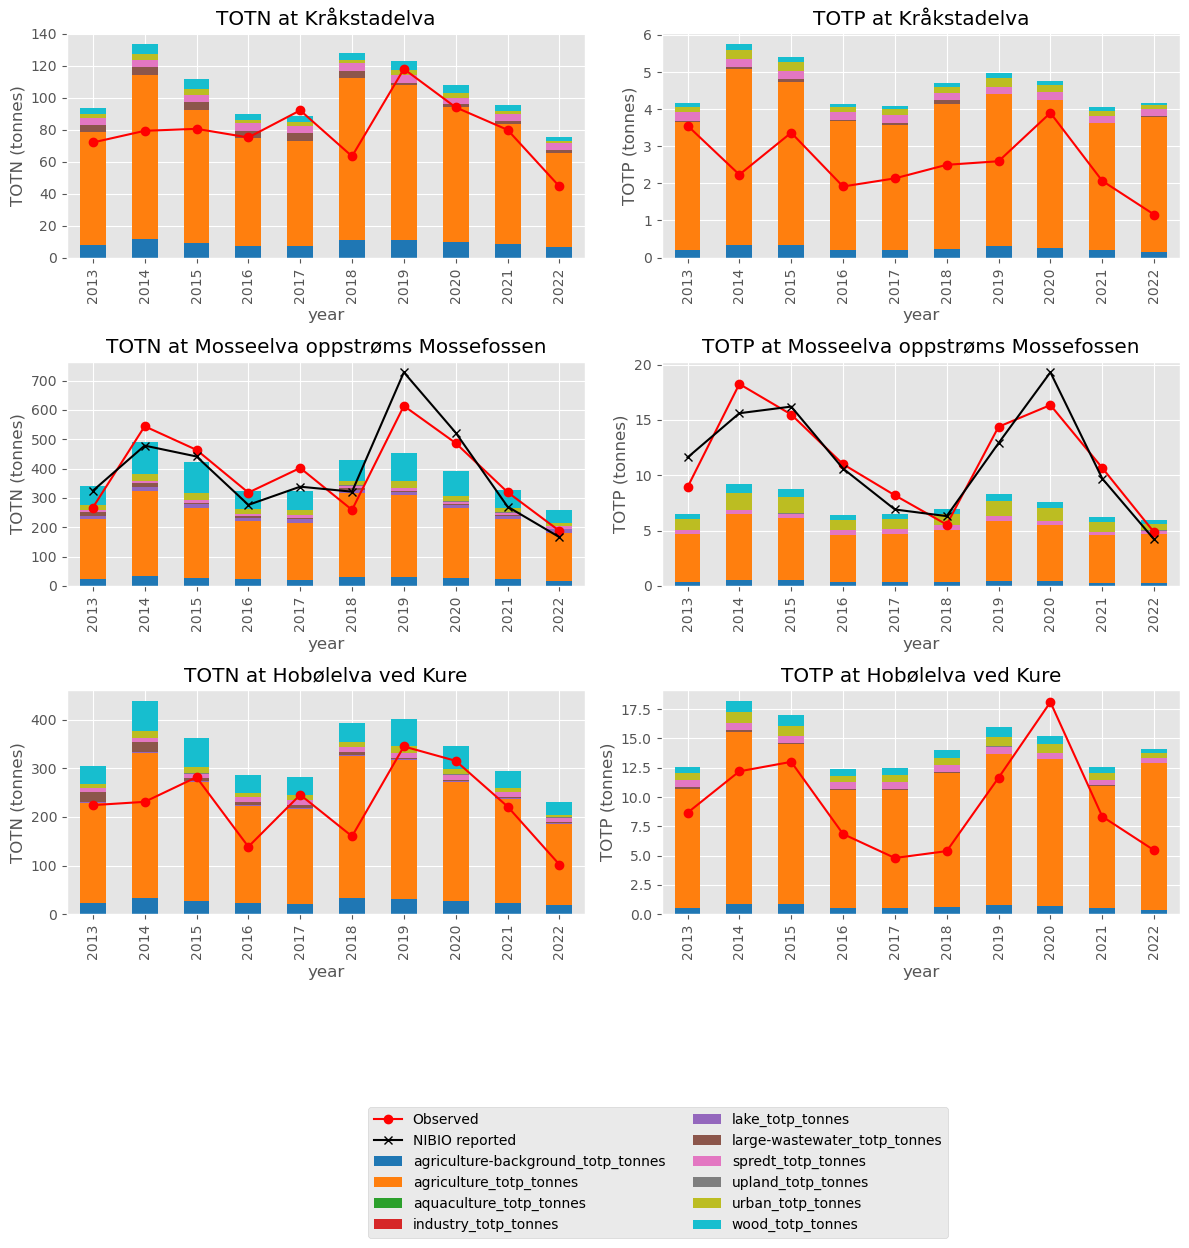

In [26]:
# Plot
pars = ["TOTN", "TOTP"]
site_list = stn_df["station_code"].tolist()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for row_idx, row in stn_df.iterrows():
    stn_id = row["station_code"]
    name = row["station_name"]
    stn_comp_df = comp_df.query("station_code == @stn_id")
    for col_idx, par in enumerate(pars):
        par_cols = [
            col
            for col in stn_comp_df.columns
            if par.lower() in (i.lower() for i in col.split("_"))
        ]

        stn_comp_par_df = stn_comp_df.set_index("year")[par_cols]

        stn_comp_par_df.drop(columns=[f"{par}_tonnes"]).plot(
            kind="bar",
            stacked=True,
            ax=axes[row_idx, col_idx],
            legend=False,
            cmap="tab10",
        )

        axes[row_idx, col_idx].plot(
            stn_comp_par_df.index - stn_comp_par_df.index.min(),
            stn_comp_par_df[f"{par}_tonnes"],
            marker="o",
            color="red",
            label="Observed",
        )
        if stn_id == "003-30718":
            axes[row_idx, col_idx].plot(
                nibio_df.index - nibio_df.index.min(),
                nibio_df[f"{par}_tonnes"],
                marker="x",
                color="black",
                label="NIBIO reported",
            )
        axes[row_idx, col_idx].set_title(f"{par} at {name}")
        axes[row_idx, col_idx].set_ylabel(f"{par} (tonnes)")
plt.tight_layout()

handles, labels = axes[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(0.8, -0.25), ncol=2)
plt.savefig("../../images/vansjo.png", dpi=200, bbox_inches="tight")

In [27]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


In [28]:
# Get regines
admin_year = 2022
reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year)

# Read single inpout file and build network
data_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
csv_path = os.path.join(
    data_fold,
    f"teotil3_input_data_nve{nve_data_year}_2013.csv",
)
df = pd.read_csv(csv_path)
g = teo.model.build_graph(df, id_col="regine", next_down_col="regine_down")

In [29]:
reg_dict = {
    "Langen": "003.F",
    "Våg og Mjær": "003.E",
    "Kråkstadelva": "003.CZ",
    "Hobølelva": "003.CO",
    "Veidalselva": "003.B5A",
    "Mørkelva": "003.B3Z",
    "Sæbyvannet og Svinna": "003.B1A",
    "Hølenelva": "004.A0",
}

['003.B1A', '003.B1B', '003.B1C']


<Axes: >

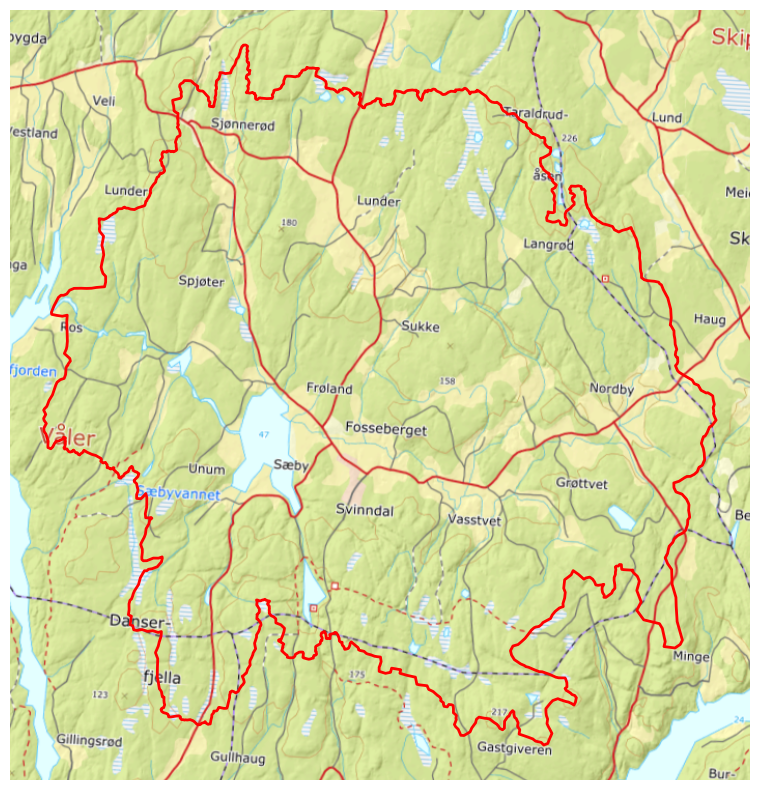

In [30]:
# Catchment of interest
reg_id = "003.B1A"

# Get upstream nodes
g2 = nx.dfs_tree(g.reverse(), reg_id).reverse()
node_list = list(g2.nodes)
print(node_list)

# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

In [31]:
data_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
df_list = []
for year in (2013, 2014):
    csv_path = os.path.join(
        data_fold,
        f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
    )
    df = pd.read_csv(csv_path)
    cols = [col for col in df.columns if ("totp" in col) and (col[:5] != "trans")]
    df = df[["regine", "regine_down"] + cols]
    df["natural_totp_kg"] = (
        df["wood_totp_kg"] + df["upland_totp_kg"] + df["agriculture-background_totp_kg"]
    )
    df.drop(
        columns=["wood_totp_kg", "upland_totp_kg", "agriculture-background_totp_kg"],
        inplace=True,
    )
    df = df.query("regine in @node_list")
    df["year"] = year
    df = df.groupby(["year"]).sum(numeric_only=True).reset_index()

    df_list.append(df)

df = pd.concat(df_list, axis="rows").round(0).set_index("year")
df[
    [
        "natural_totp_kg",
        "agriculture_totp_kg",
        "large-wastewater_totp_kg",
        "spredt_totp_kg",
        "urban_totp_kg",
    ]
].T

year                        2013    2014
natural_totp_kg            677.0  1125.0
agriculture_totp_kg       2325.0  3236.0
large-wastewater_totp_kg    20.0     1.0
spredt_totp_kg              24.0    24.0
urban_totp_kg               52.0    86.0

In [32]:
xl_path = r"/home/jovyan/shared/common/teotil3/evaluation/vansjo_subcats_nutrient_budget_comparison.xlsx"
df = pd.read_excel(xl_path, sheet_name="long")
df

Catchment       Source            Model  TOTP_kg
0       Langen   Background       NIBIO_2012      632
1       Langen  Agriculture       NIBIO_2012      456
2       Langen   Wastewater       NIBIO_2012       62
3       Langen       Spredt       NIBIO_2012       97
4       Langen        Urban       NIBIO_2012        0
..         ...          ...              ...      ...
115  Hølenelva   Background  TEOTIL3_2013-14     1206
116  Hølenelva  Agriculture  TEOTIL3_2013-14    14788
117  Hølenelva   Wastewater  TEOTIL3_2013-14       34
118  Hølenelva       Spredt  TEOTIL3_2013-14      647
119  Hølenelva        Urban  TEOTIL3_2013-14      980

[120 rows x 4 columns]

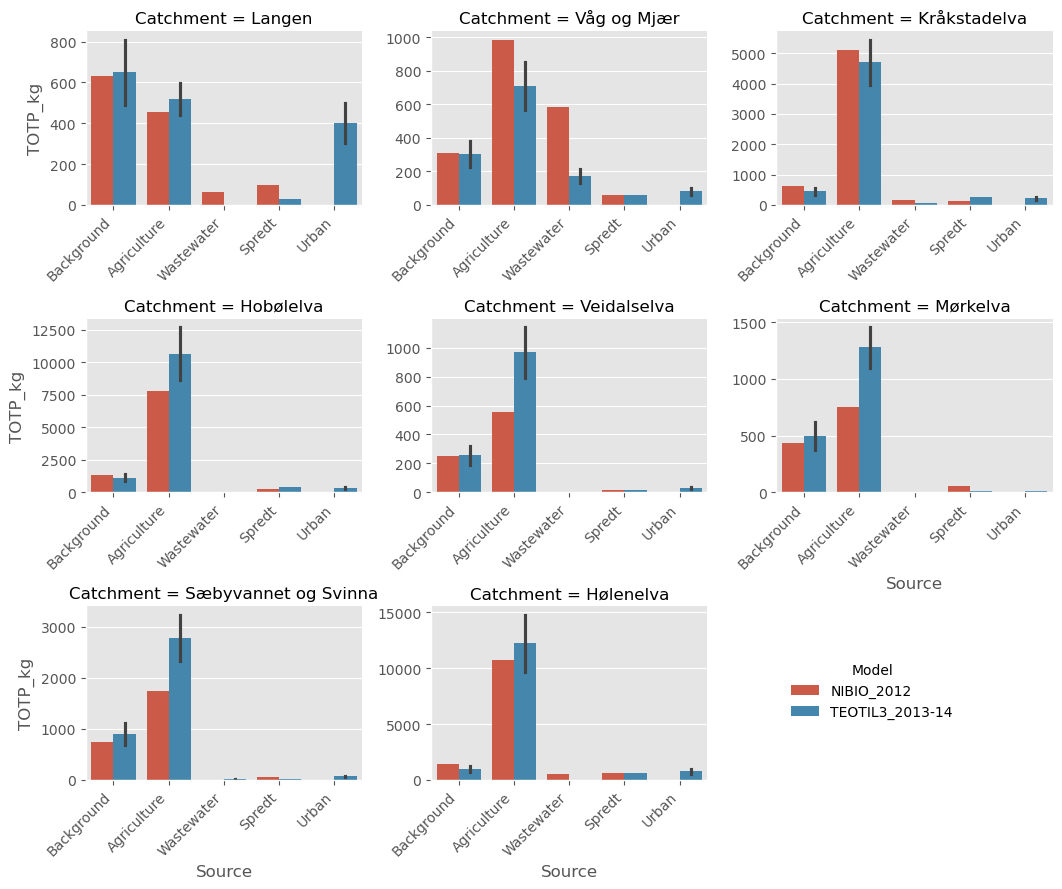

In [33]:
g = sn.catplot(
    df,
    x="Source",
    y="TOTP_kg",
    col="Catchment",
    col_wrap=3,
    hue="Model",
    kind="bar",
    sharex=False,
    sharey=False,
    height=3,
    aspect=1,
)
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
g._legend.set_bbox_to_anchor((0.9, 0.22))
plt.tight_layout()

## Avlastningsbehov

In [34]:
# Get regines
admin_year = 2022
reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year)

# Read single input file and build network
data_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
csv_path = os.path.join(
    data_fold,
    f"teotil3_input_data_nve{nve_data_year}_2013.csv",
)
in_df = pd.read_csv(csv_path)
g = teo.model.build_graph(in_df, id_col="regine", next_down_col="regine_down")

# Read lake properties
lake_df = pd.read_csv("../../data/lake_residence_times_10m_dem.csv")

<Axes: >

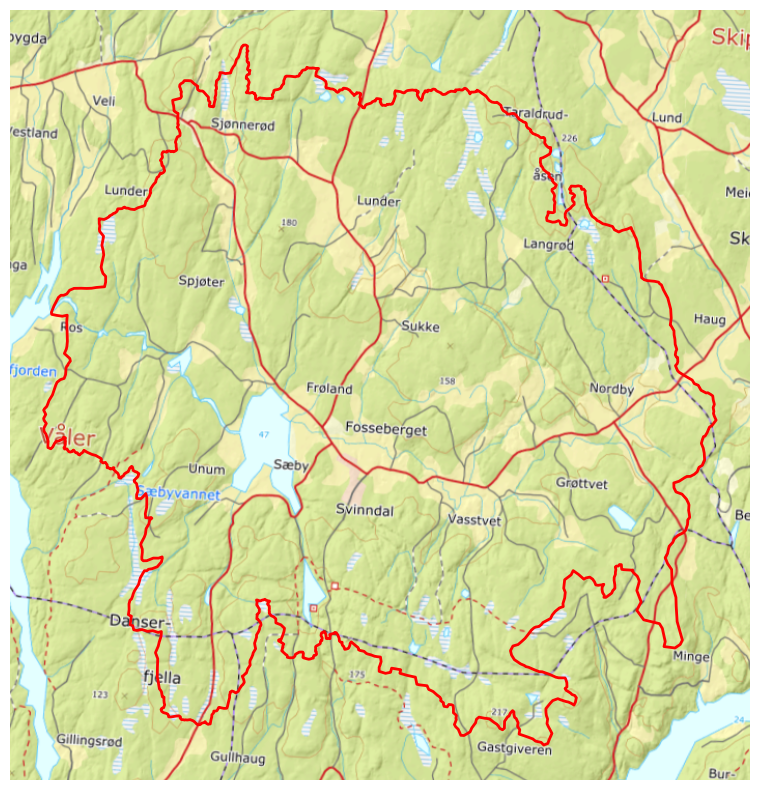

In [35]:
# Catchment of interest
reg_id = "003.B1A"

# Period of interest
st_yr, end_yr = 2013, 2022

# Parameter of interest
par = "TOTP"
ges_conc = 16  # ug/l

# # Get upstream nodes
# g2 = nx.dfs_tree(g.reverse(), reg_id).reverse()
# node_list = list(g2.nodes)
# print(node_list)

# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

In [36]:
assert par in ("TOTP", "TOTN", "TOC")

# Find lakes in regine of interest
reg_lake_df = lake_df.query("regine == @reg_id")
lake_id_list = reg_lake_df["vatnLnr"].tolist()

# Get model results for regine
reg_mod_df = mod_df.query(
    "(regine == @reg_id) and (year >= @st_yr) and (year <= @end_yr)"
).copy()
del reg_mod_df["regine"]
reg_mod_df.set_index("year", inplace=True)

# Estimate current outflow concs
frac_dict = {
    "TOTP": ["TOTP", "TDP", "TPP"],
    "TOTN": ["TOTN", "DIN", "TON"],
    "TOC": ["TOC"],
}
fracs = frac_dict[par]
cur_conc_dict = {}
cur_flux_dict = {}
for frac in fracs:
    cols = [col for col in reg_mod_df.columns if f"_{frac.lower()}_" in col]
    flux_df = reg_mod_df[cols].sum(axis="columns")
    flux_df.name = f"{frac}_tonnes"
    vol_df = reg_mod_df["q_m3/s"] * 365.25 * 24 * 60 * 60
    vol_df.name = "vol_m3"
    frac_df = pd.concat([vol_df, flux_df], axis="columns")
    if par == "TOC":
        # mg/l
        frac_df[f"{frac}_mg/l"] = (frac_df[f"{frac}_tonnes"] * 1e9) / (
            frac_df["vol_m3"] * 1000
        )
    else:
        # ug/l
        frac_df[f"{frac}_ug/l"] = (frac_df[f"{frac}_tonnes"] * 1e12) / (
            frac_df["vol_m3"] * 1000
        )
    conc_col = [col for col in frac_df if col.endswith("g/l")]
    mean_conc = frac_df[conc_col].values.mean()
    cur_conc_dict[conc_col[0]] = mean_conc
    flux_col = f"{frac}_tonnes"
    mean_flux = frac_df[flux_col].values.mean() * 1000  # kg
    cur_flux_dict[f"{frac}_kg"] = mean_flux


# Get current outflow fluxes
cols = [col for col in reg_mod_df.columns if par.lower() in col]
flux_df = reg_mod_df[cols]
avg_flux_df = flux_df.mean(axis="rows")
avg_tot_flux = avg_flux_df.sum()
src_df = 100 * avg_flux_df / avg_tot_flux
avg_tot_flux_kg = avg_tot_flux * 1000
src_df.sort_values(ascending=False, inplace=True)

# Get transmission
if par == "TOC":
    trans = in_df.query("regine == @reg_id")["trans_toc"].iloc[0]
elif par == "TOTP":
    trans_tdp = in_df.query("regine == @reg_id")["trans_tdp"].iloc[0]
    trans_tpp = in_df.query("regine == @reg_id")["trans_tpp"].iloc[0]
    in_tdp = cur_flux_dict["TDP_kg"] / trans_tdp
    in_tpp = cur_flux_dict["TPP_kg"] / trans_tpp
    trans = cur_flux_dict["TOTP_kg"] / (in_tdp + in_tpp)
else:
    trans_din = in_df.query("regine == @reg_id")["trans_din"].iloc[0]
    trans_ton = in_df.query("regine == @reg_id")["trans_ton"].iloc[0]
    in_din = cur_flux_dict["DIN_kg"] / trans_din
    in_ton = cur_flux_dict["TON_kg"] / trans_ton
    trans = cur_flux_dict["TOTN_kg"] / (in_din + in_ton)

# Estimate acceptable outflow flux for GES
avg_ann_vol = (reg_mod_df["q_m3/s"] * 365.25 * 24 * 60 * 60).mean()
max_out_flux_ges = ges_conc * 1000 * avg_ann_vol / 1e9  # kg

# Estimate acceptable inputs for GES
max_in_flux_ges = max_out_flux_ges / trans  # kg

# Estimate current inputs
in_flux_kg = avg_tot_flux_kg / trans

# Load reduction
red_target = in_flux_kg - max_in_flux_ges
red_target_pct = 100 * red_target / in_flux_kg

print(f"Selected regine:\t{reg_id}.")
print(f"Selected parameter:\t{par}.")
print(f"Time period:\t\t{st_yr} to {end_yr}.")
print(f"Concentration for GES:\t{ges_conc} ug/l.")
print("")
print(f"The regine contains {len(lake_id_list)} lake(s):")
print(f"\tvatnLnrs:\t{lake_id_list}")
print("")
print(f"Estimated mean outflow concentration(s) ({st_yr}-{end_yr}):")
for frac, value in cur_conc_dict.items():
    print(f"\t{frac:<30}{value:>10.1f}")
print("")
print(f"Estimated mean outflow flux(es) ({st_yr}-{end_yr}):")
for frac, value in cur_flux_dict.items():
    print(f"\t{frac:<30}{value:>10.0f}")
print("")
print(f"Source apportionment for outflow {par}:")
for src, pct in src_df.items():
    src = src.split("_")[0] + " (%)"
    if pct > 0:
        print(f"\t{src.capitalize():<30}{pct:>10.1f}")
print("")
print(f"Maximum outflow flux for GES (kg)\t{max_out_flux_ges:>8.0f}")
print(f"Transmission factor (weighted) for {par:<4}{trans:>9.2f}")
print(f"Maximum inflow flux for GES (kg)\t{max_in_flux_ges:>8.0f}")
print(f"Estimated inflow flux {st_yr}-{end_yr} (kg)\t{in_flux_kg:>8.0f}")
print(f"Load reduction target for GES (kg)\t{red_target:>8.0f} ({red_target_pct:.1f}%)")

Selected regine:	003.B1A.
Selected parameter:	TOTP.
Time period:		2013 to 2022.
Concentration for GES:	16 ug/l.

The regine contains 1 lake(s):
	vatnLnrs:	[5823]

Estimated mean outflow concentration(s) (2013-2022):
	TOTP_ug/l                           24.0
	TDP_ug/l                             8.6
	TPP_ug/l                            15.4

Estimated mean outflow flux(es) (2013-2022):
	TOTP_kg                             1493
	TDP_kg                               536
	TPP_kg                               958

Source apportionment for outflow TOTP:
	Agriculture (%)                     71.9
	Wood (%)                            18.5
	Agriculture-background (%)           5.1
	Urban (%)                            2.6
	Spredt (%)                           1.3
	Large-wastewater (%)                 0.3
	Upland (%)                           0.3

Maximum outflow flux for GES (kg)	    1030
Transmission factor (weighted) for TOTP     0.89
Maximum inflow flux for GES (kg)	    1158
Estimated inflow 